# **Neural Network Regression with California Housing**

## **Loading The Dataset**

In [1]:
import pandas as pd 
from sklearn.datasets import fetch_california_housing

# Load dataset 
data = fetch_california_housing(as_frame=True)
df = data.frame

# Target column is 'MedHouseVal'
target_name = data.target_names[0]
print("Columns:", list(df.columns))
print(df[target_name].describe())

Columns: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']
count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64


## **Split Data and Scale Features**

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop(columns=[target_name])
y = df[target_name]

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s = scaler.transform(X_val)

## **Build A Regression Neural Network**

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

n_features = X_train.shape[1]

def build_model(hidden_units, activation='relu', optimizer='adam', lr=None):
    model = models.Sequential()
    model.add(layers.Input(shape=(n_features,)))
    for u in hidden_units:
        model.add(layers.Dense(u, activation=activation))
    # Output layer: linear activation for regression
    model.add(layers.Dense(1, activation='linear'))

    # Optimizer
    if optimizer == 'adam':
        opt = optimizers.Adam(learning_rate=lr or 0.001)
    elif optimizer == 'sgd':
        opt = optimizers.SGD(learning_rate=lr or 0.01, momentum=0.9)
    else:
        raise ValueError("Unsupported optimizer")

    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

## **Train Models With Different Configs**

In [4]:
import time

configs = [
    {'name':'relu_adam_shallow', 'hidden':[64,32], 'activation':'relu', 'optimizer':'adam'},
    {'name':'tanh_adam_shallow', 'hidden':[64,32], 'activation':'tanh', 'optimizer':'adam'},
    {'name':'relu_sgd_shallow',  'hidden':[64,32], 'activation':'relu', 'optimizer':'sgd'},
    {'name':'relu_adam_deep',    'hidden':[128,64,32,16], 'activation':'relu', 'optimizer':'adam'},
]

epochs = 100
batch_size = 32
results = []
histories = {}

for cfg in configs:
    print(f"\nTraining {cfg['name']}...")
    model = build_model(cfg['hidden'], activation=cfg['activation'], optimizer=cfg['optimizer'])
    start = time.perf_counter()
    history = model.fit(X_train_s, y_train,
                        validation_data=(X_val_s, y_val),
                        epochs=epochs, batch_size=batch_size, verbose=0)
    elapsed = time.perf_counter() - start

    histories[cfg['name']] = history.history

    # Save metrics
    results.append({
        'model': cfg['name'],
        'val_mse': history.history['val_loss'][-1],
        'val_mae': history.history['val_mae'][-1],
        'time_s': elapsed
    })


Training relu_adam_shallow...

Training tanh_adam_shallow...

Training relu_sgd_shallow...

Training relu_adam_deep...


## **Evaluate Models (MSE, MAE, RMSE)**

In [5]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

eval_results = []
for cfg in configs:
    model = build_model(cfg['hidden'], activation=cfg['activation'], optimizer=cfg['optimizer'])
    model.fit(X_train_s, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    y_pred_train = model.predict(X_train_s).ravel()
    y_pred_val = model.predict(X_val_s).ravel()

    train_mse = mean_squared_error(y_train, y_pred_train)
    val_mse   = mean_squared_error(y_val, y_pred_val)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    val_mae   = mean_absolute_error(y_val, y_pred_val)

    eval_results.append({
        'model': cfg['name'],
        'train_mse': train_mse,
        'val_mse': val_mse,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'train_rmse': math.sqrt(train_mse),
        'val_rmse': math.sqrt(val_mse),
    })

df_eval = pd.DataFrame(eval_results)
print(df_eval)

516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
               model  train_mse   val_mse  train_mae   val_mae  train_rmse  \
0  relu_adam_shallow   0.228388  0.270008   0.324461  0.345741    0.477900   
1  tanh_adam_shallow   0.234689  0.267955   0.326065  0.344818    0.484447   
2   relu_sgd_shallow   1.337090  1.311605   0.917272  0.909663    1.156326   
3     relu_adam_deep   0.148225  0.256547   0.264812  0.331260    0.385001   

   val_rmse  
0  0.519623  
1  0.517643  
2  1.145253  
3  0.506505  


## **Plot Learning Curves**

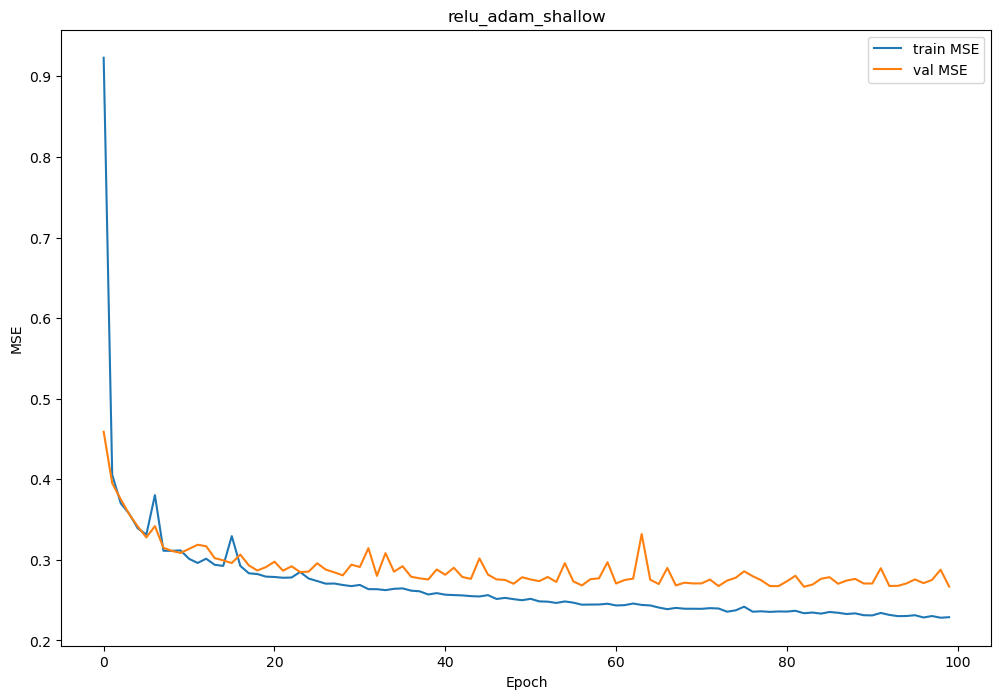

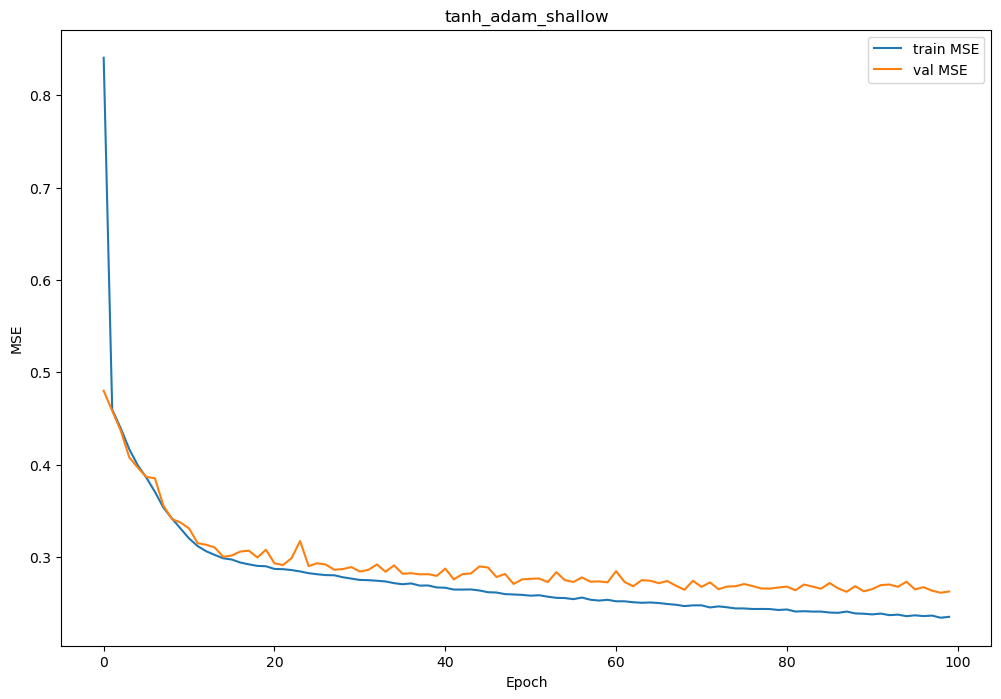

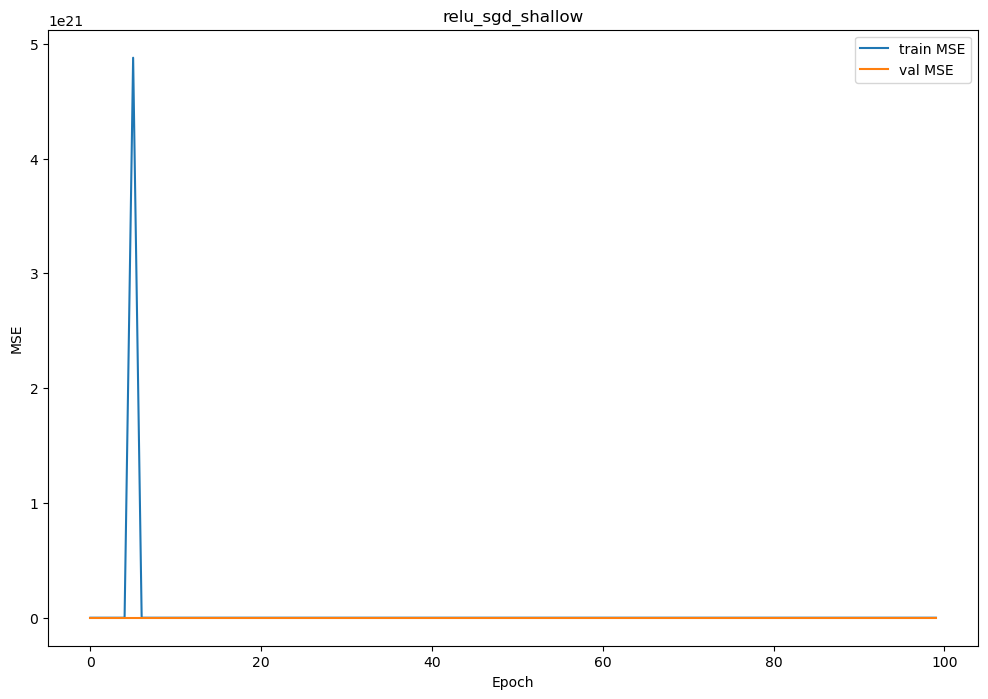

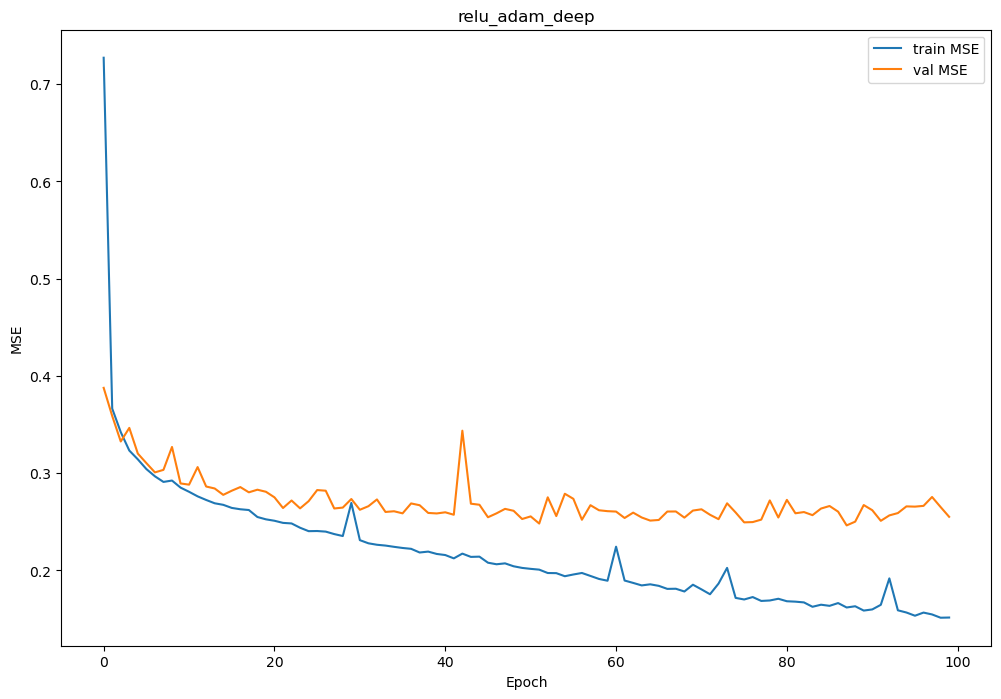

In [8]:
import matplotlib.pyplot as plt

for name, hist in histories.items():
    plt.figure(figsize=(12,8))
    plt.plot(hist['loss'], label="train MSE")
    plt.plot(hist['val_loss'], label="val MSE")
    plt.title(name)
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()